# Setup

In [8]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import datetime
import cv2
from keras import backend as K
from keras.layers import Layer,InputSpec
from keras import layers
import keras.layers as kl
from glob import glob
from sklearn.metrics import roc_curve, auc
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from tensorflow.keras import callbacks 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from  matplotlib import pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate, Dense, Conv2D, MaxPooling2D, Flatten, Input, Activation, add, AveragePooling2D, BatchNormalization, Dropout
%matplotlib inline
import shutil
from sklearn.metrics import  precision_score, recall_score, accuracy_score,classification_report ,confusion_matrix
from tensorflow.python.platform import build_info as tf_build_info
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [9]:
tf.config.list_physical_devices('GPU')

[]

# Data Preparation

In [10]:
# Environment variable
main_dir = 'D:/Data/HAM100000 - Harvard Dataset'
main_img_dir = main_dir + '/img_data'
preprocessed_data_dir = main_dir + '/preprocessed_data'
train_dir = preprocessed_data_dir + '/train'
test_dir = preprocessed_data_dir + '/val'
train_label = preprocessed_data_dir + '/train_label.csv'
val_label = preprocessed_data_dir + '/val_label.csv'

model_path = 'densenetSoftAtt_10split_LRStr.hdf5'

In [11]:
target_size = (224, 224)
def Get_data(df_path, img_path, _target_size):
    img_list = []
    labels = []
    ages = []
    sex_list = []
    localizations = []
    
    df = pd.read_csv(df_path)
    for index, row in df.iterrows():
        img_list.append(cv2.imread(img_path + '/' + row['image_id'] + '.jpg'))
        labels.append(row['dx'])
        ages.append(float(row['age']))
        sex_list.append(row['sex'])
        localizations.append(row['localization'])
    for x in range(len(img_list)):
        img_list[x] = tf.keras.preprocessing.image.smart_resize(img_list[x], _target_size)
        img_list[x] = tf.keras.applications.mobilenet.preprocess_input(img_list[x])
    le = preprocessing.LabelEncoder()
    le.fit(labels)
    labels = le.transform(labels)
    labels = tf.keras.utils.to_categorical(labels)
    return (img_list, ages, sex_list, localizations), labels

In [12]:
train_df = pd.read_csv(train_label)
train_df.head()

,Unnamed: 0,image_id,dx,age,sex,localization
0,0,ISIC_0027419,bkl,80.0,male,scalp
1,1,ISIC_0025030,bkl,80.0,male,scalp
2,2,ISIC_0026769,bkl,80.0,male,scalp
3,3,ISIC_0025661,bkl,80.0,male,scalp
4,4,ISIC_0031633,bkl,75.0,male,ear


In [13]:
val_df = pd.read_csv(val_label)
val_df.head()

,Unnamed: 0,image_id,dx,age,sex,localization
0,9382,ISIC_0025101,nv,5.0,female,foot
1,1741,ISIC_0033444,mel,50.0,male,abdomen
2,9974,ISIC_0024654,akiec,75.0,female,lower extremity
3,4429,ISIC_0026747,nv,40.0,male,lower extremity
4,445,ISIC_0025928,bkl,85.0,female,back


## Training Data

In [14]:
(train_img_lst, train_ages, train_sexes, train_localizations), labels = Get_data(train_label, main_img_dir, target_size)

In [15]:
any(elem is None for elem in train_img_lst)

False

In [16]:
print("Number of images: {}".format(len(train_img_lst)))
print("Image shape: {0} {1}".format(train_img_lst[0].shape[0], train_img_lst[0].shape[1]))
print("Example of Age: {}".format(train_ages[0]))
print("Example of Sex: {}".format(train_sexes[0]))
print("Example of Localization: {}".format(train_localizations[0]))

Number of images: 8962
Image shape: 224 224
Example of Age: 80.0
Example of Sex: male
Example of Localization: scalp


## Validation Data

In [17]:
(val_img_lst, val_ages, val_sexes, val_localizations), val_labels = Get_data(val_label, main_img_dir, target_size)

In [18]:
any(elem is None for elem in val_img_lst)

False

In [19]:
print("Number of images: {}".format(len(val_img_lst)))
print("Image shape: {0} {1}".format(val_img_lst[0].shape[0], val_img_lst[0].shape[1]))
print("Example of Age: {}".format(val_ages[0]))
print("Example of Sex: {}".format(val_sexes[0]))
print("Example of Localization: {}".format(val_localizations[0]))

Number of images: 996
Image shape: 224 224
Example of Age: 5.0
Example of Sex: female
Example of Localization: foot


# Model

## Input Block

In [20]:
age_input = tf.keras.Input(shape=(1,), name='age', dtype=tf.float32)
sex_input = tf.keras.Input(shape=(1,), name='sex', dtype=tf.string)
localizations_input = tf.keras.Input(shape=(1,), name='localization', dtype=tf.string)

inputs = {'age' : age_input,
         'sex' : sex_input,
         'local' : localizations_input}

In [21]:
norm = layers.Normalization()
norm.adapt(np.array(train_df[['age']]))
age_norm_input = norm(age_input)
age_norm_input

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization')>

In [22]:
# Sex input
sex_lookup = layers.StringLookup(vocabulary=np.unique(train_df['sex']))
sex_one_hot = layers.CategoryEncoding(num_tokens=sex_lookup.vocabulary_size())

preprocessed_sex_input = sex_lookup(sex_input)
preprocessed_sex_input = sex_one_hot(preprocessed_sex_input)
preprocessed_sex_input

<KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'category_encoding')>

In [23]:
# Localization input
local_lookup = layers.StringLookup(vocabulary=np.unique(train_df['localization']))
local_one_hot = layers.CategoryEncoding(num_tokens=local_lookup.vocabulary_size())

preprocess_local_input = local_lookup(localizations_input)
preprocess_local_input = local_one_hot(preprocess_local_input)
preprocess_local_input

<KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'category_encoding_1')>

In [24]:
preprocessed_inputs = [age_norm_input, preprocessed_sex_input, preprocess_local_input]
preprocessed_inputs_cat = layers.Concatenate()(preprocessed_inputs)

# preprocessed_Model = tf.keras.Model(inputs, preprocessed_inputs_cat)
# tf.keras.utils.plot_model(model = preprocessed_Model , rankdir="LR", dpi=72, show_shapes=True)

preprocessed_inputs_cat

<KerasTensor: shape=(None, 21) dtype=float32 (created by layer 'concatenate')>

## Soft Attention

In [25]:
from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
import tensorflow as tf

In [26]:
class SoftAttention(Layer):
    def __init__(self,ch,m,concat_with_x=False,aggregate=False,**kwargs):
        self.channels=int(ch)
        self.multiheads = m
        self.aggregate_channels = aggregate
        self.concat_input_with_scaled = concat_with_x

        
        super(SoftAttention,self).__init__(**kwargs)

    def build(self,input_shape):

        self.i_shape = input_shape

        kernel_shape_conv3d = (self.channels, 3, 3) + (1, self.multiheads) # DHWC
    
        self.out_attention_maps_shape = input_shape[0:1]+(self.multiheads,)+input_shape[1:-1]
        
        if self.aggregate_channels==False:

            self.out_features_shape = input_shape[:-1]+(input_shape[-1]+(input_shape[-1]*self.multiheads),)
        else:
            if self.concat_input_with_scaled:
                self.out_features_shape = input_shape[:-1]+(input_shape[-1]*2,)
            else:
                self.out_features_shape = input_shape
        

        self.kernel_conv3d = self.add_weight(shape=kernel_shape_conv3d,
                                        initializer='he_uniform',
                                        name='kernel_conv3d')
        self.bias_conv3d = self.add_weight(shape=(self.multiheads,),
                                      initializer='zeros',
                                      name='bias_conv3d')

        super(SoftAttention, self).build(input_shape)

    def call(self, x):

        exp_x = K.expand_dims(x,axis=-1)

        c3d = K.conv3d(exp_x,
                     kernel=self.kernel_conv3d,
                     strides=(1,1,self.i_shape[-1]), padding='same', data_format='channels_last')
        conv3d = K.bias_add(c3d,
                        self.bias_conv3d)
        conv3d = kl.Activation('relu')(conv3d)

        conv3d = K.permute_dimensions(conv3d,pattern=(0,4,1,2,3))

        
        conv3d = K.squeeze(conv3d, axis=-1)
        conv3d = K.reshape(conv3d,shape=(-1, self.multiheads ,self.i_shape[1]*self.i_shape[2]))

        softmax_alpha = K.softmax(conv3d, axis=-1) 
        softmax_alpha = kl.Reshape(target_shape=(self.multiheads, self.i_shape[1],self.i_shape[2]))(softmax_alpha)

        
        if self.aggregate_channels==False:
            exp_softmax_alpha = K.expand_dims(softmax_alpha, axis=-1)       
            exp_softmax_alpha = K.permute_dimensions(exp_softmax_alpha,pattern=(0,2,3,1,4))
   
            x_exp = K.expand_dims(x,axis=-2)
   
            u = kl.Multiply()([exp_softmax_alpha, x_exp])   
  
            u = kl.Reshape(target_shape=(self.i_shape[1],self.i_shape[2],u.shape[-1]*u.shape[-2]))(u)

        else:
            exp_softmax_alpha = K.permute_dimensions(softmax_alpha,pattern=(0,2,3,1))

            exp_softmax_alpha = K.sum(exp_softmax_alpha,axis=-1)

            exp_softmax_alpha = K.expand_dims(exp_softmax_alpha, axis=-1)

            u = kl.Multiply()([exp_softmax_alpha, x])   

        if self.concat_input_with_scaled:
            o = kl.Concatenate(axis=-1)([u,x])
        else:
            o = u
        
        return [o, softmax_alpha]

    def compute_output_shape(self, input_shape): 
        return [self.out_features_shape, self.out_attention_maps_shape]

    
    def get_config(self):
        return super(SoftAttention,self).get_config()

## Base Model

In [27]:
densenet = tf.keras.applications.DenseNet201(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,

)

inputs['image'] = densenet.input

# Exclude the last 28 layers of the model.
densenet_output = densenet.layers[-28].output

## Final Model

In [28]:
attention_layer,map2 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(densenet_output.shape[-1]),name='soft_attention')(densenet_output)
attention_layer=(MaxPooling2D(pool_size=(2, 2),padding="same")(attention_layer))
densenet_output=(MaxPooling2D(pool_size=(2, 2),padding="same")(densenet_output))

densenet_output = layers.Concatenate()([densenet_output, attention_layer])
densenet_output = Activation('relu')(densenet_output)
densenet_output = Dropout(0.5)(densenet_output)

In [29]:
output = Flatten()(densenet_output)
preprocessed_inputs_cat = (layers.Dense(4096, activation = 'relu')(preprocessed_inputs_cat))
preprocessed_inputs_cat = Dropout(.4)(preprocessed_inputs_cat)
output = layers.Concatenate()([output, preprocessed_inputs_cat])
output = Dense(7, activation='softmax')(output)
model = Model(inputs=inputs, outputs=output)

In [30]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

## Training

In [31]:
feature_dict = {'age' : np.array(train_ages),
                'sex' : np.array(train_sexes),
                'local' : np.array(train_localizations),
                'image' : np.array(train_img_lst)}

In [32]:
val_dict = {'age' : np.array(val_ages),
                'sex' : np.array(val_sexes),
                'local' : np.array(val_localizations),
                'image' : np.array(val_img_lst)}

In [33]:
class_weights = { 
                    0: 4.37,  # akiec
                    1: 2.78,  # bcc
                    2: 1.3,  # bkl
                    3: 12.44,  # df
                    4: 1.28,  # mel
                    5: 0.21,  # nv
                    6: 10,  # vasc
                }

checkpoint=  ModelCheckpoint(filepath = model_path,monitor='val_accuracy',save_best_only=True,save_weights_only=True)

In [34]:
opt1=tf.keras.optimizers.Adam(learning_rate=0.001,epsilon=0.1)
model.compile(optimizer=opt1,
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [35]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              verbose = 1, mode = 'min',
                              patience=5, min_lr=0.0000001)

In [36]:
batch_size = 32 

Earlystop = EarlyStopping(monitor='val_loss', mode='min',patience=35, min_delta=0.001)

with tf.device('/GPU:0'):
    history = model.fit(feature_dict, labels,
                        steps_per_epoch=(len(train_df)/10),
                        epochs=500,
                        validation_data=(val_dict, val_labels), 
                        validation_steps=len(val_df)/batch_size,
                        callbacks=[checkpoint, Earlystop, reduce_lr],
                        class_weight=class_weights)

Epoch 1/500
896/896 [==============================] - 7027s 8s/step - loss: 1.8263 - accuracy: 0.3429 - val_loss: 1.4893 - val_accuracy: 0.4789 - lr: 0.0010
Epoch 2/500
896/896 [==============================] - 7452s 8s/step - loss: 1.1360 - accuracy: 0.6146 - val_loss: 0.8979 - val_accuracy: 0.6827 - lr: 0.0010
Epoch 3/500
896/896 [==============================] - 7857s 9s/step - loss: 0.8286 - accuracy: 0.6462 - val_loss: 0.9675 - val_accuracy: 0.6185 - lr: 0.0010
Epoch 4/500
896/896 [==============================] - 8115s 9s/step - loss: 0.6399 - accuracy: 0.7077 - val_loss: 0.7550 - val_accuracy: 0.7199 - lr: 0.0010
Epoch 5/500
896/896 [==============================] - 7895s 9s/step - loss: 0.5081 - accuracy: 0.7417 - val_loss: 0.7567 - val_accuracy: 0.7440 - lr: 0.0010
Epoch 6/500
896/896 [==============================] - 7979s 9s/step - loss: 0.4020 - accuracy: 0.7718 - val_loss: 0.6722 - val_accuracy: 0.7480 - lr: 0.0010
Epoch 7/500
896/896 [==============================]

Epoch 46/500
896/896 [==============================] - 8360s 9s/step - loss: 0.0069 - accuracy: 0.9953 - val_loss: 0.3963 - val_accuracy: 0.8896 - lr: 1.0000e-07
Epoch 47/500
896/896 [==============================] - 8385s 9s/step - loss: 0.0067 - accuracy: 0.9962 - val_loss: 0.3991 - val_accuracy: 0.8906 - lr: 1.0000e-07
Epoch 48/500
896/896 [==============================] - 8402s 9s/step - loss: 0.0071 - accuracy: 0.9971 - val_loss: 0.3998 - val_accuracy: 0.8886 - lr: 1.0000e-07
Epoch 49/500
896/896 [==============================] - 8324s 9s/step - loss: 0.0078 - accuracy: 0.9945 - val_loss: 0.3953 - val_accuracy: 0.8936 - lr: 1.0000e-07
Epoch 50/500
896/896 [==============================] - 7975s 9s/step - loss: 0.0079 - accuracy: 0.9951 - val_loss: 0.3980 - val_accuracy: 0.8896 - lr: 1.0000e-07
Epoch 51/500
896/896 [==============================] - 7862s 9s/step - loss: 0.0081 - accuracy: 0.9950 - val_loss: 0.3996 - val_accuracy: 0.8876 - lr: 1.0000e-07
Epoch 52/500
896/896 [

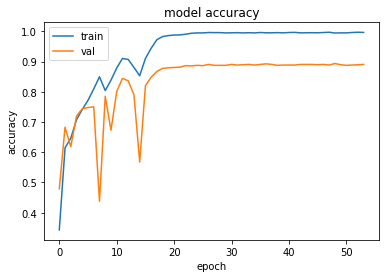

In [37]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

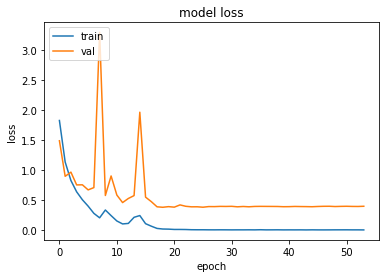

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [39]:
from tensorflow.keras import models
model.load_weights(model_path)

In [40]:
batch_size = 32 
predictions = model.predict(val_dict, steps=len(val_df)/batch_size, verbose=0)

# Classification report

In [41]:
#geting predictions on test dataset
y_pred = np.argmax(predictions, axis=1)
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
#getting the true labels per image 
y_true = np.argmax(val_labels, axis=1)
#getting the predicted labels per image 
y_prob=predictions
from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

# Creating classification report 
report = classification_report(y_true, y_pred, target_names=targetnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

       akiec       0.73      0.73      0.73        33
         bcc       0.76      0.86      0.81        51
         bkl       0.80      0.82      0.81       109
          df       0.89      0.67      0.76        12
         mel       0.80      0.74      0.77       111
          nv       0.95      0.94      0.95       666
        vasc       0.78      1.00      0.88        14

    accuracy                           0.89       996
   macro avg       0.81      0.82      0.81       996
weighted avg       0.89      0.89      0.89       996



# Confusion Matrix Metrics

In [42]:
from sklearn.metrics import multilabel_confusion_matrix
multi_cm = multilabel_confusion_matrix(y_true, y_pred)
#print(multi_cm)

# TN     FP
# FN     TP

In [43]:
def cm_compute(_cm, _index, _name):
    print("Confusion Matrix of {}".format(_name))
    print(_cm[index])
    TP = _cm[index][1][1]
    FP = _cm[index][0][1]
    FN = _cm[index][1][0]
    TN = _cm[index][0][0]
    print("True Positive of {0}: {1}".format(_name, TP))
    print("False Positive of {0}: {1}".format(_name, FP))
    print("False Negative of {0}: {1}".format(_name, FN))
    print("True Negative of {0}: {1}".format(_name, TN))
    sensitivity = TP/(TP + FN)
    specificity = TN/(TN + FP)
    print("Sensitivity of {0}: {1}".format(_name, sensitivity))
    print("Specificity of {0}: {1}".format(_name, specificity))
    print("Precision of {0}: {1}".format(_name, TP/(TP + FP)))
    print("Accuracy of {0}: {1}".format(_name, (TP+TN)/(TP + FP + FN + TN)))
    print("Balanced Accuracy of {0} : {1}".format(_name, (sensitivity + specificity)/2))
    print("F1 Score of {0}: {1}".format(_name, (2*TP)/(2*TP + FP + FN)))

### akiec       

In [44]:
index = 0
cm_compute(multi_cm, index, targetnames[index])

Confusion Matrix of akiec
[[954   9]
 [  9  24]]
True Positive of akiec: 24
False Positive of akiec: 9
False Negative of akiec: 9
True Negative of akiec: 954
Sensitivity of akiec: 0.7272727272727273
Specificity of akiec: 0.9906542056074766
Precision of akiec: 0.7272727272727273
Accuracy of akiec: 0.9819277108433735
Balanced Accuracy of akiec : 0.858963466440102
F1 Score of akiec: 0.7272727272727273


### bcc       

In [45]:
index = 1
cm_compute(multi_cm, index, targetnames[index])

Confusion Matrix of bcc
[[931  14]
 [  7  44]]
True Positive of bcc: 44
False Positive of bcc: 14
False Negative of bcc: 7
True Negative of bcc: 931
Sensitivity of bcc: 0.8627450980392157
Specificity of bcc: 0.9851851851851852
Precision of bcc: 0.7586206896551724
Accuracy of bcc: 0.9789156626506024
Balanced Accuracy of bcc : 0.9239651416122004
F1 Score of bcc: 0.8073394495412844


### bkl

In [46]:
index = 2
cm_compute(multi_cm, index, targetnames[index])

Confusion Matrix of bkl
[[865  22]
 [ 20  89]]
True Positive of bkl: 89
False Positive of bkl: 22
False Negative of bkl: 20
True Negative of bkl: 865
Sensitivity of bkl: 0.8165137614678899
Specificity of bkl: 0.9751972942502819
Precision of bkl: 0.8018018018018018
Accuracy of bkl: 0.9578313253012049
Balanced Accuracy of bkl : 0.8958555278590858
F1 Score of bkl: 0.8090909090909091


### df 

In [47]:
index = 3
cm_compute(multi_cm, index, targetnames[index])

Confusion Matrix of df
[[983   1]
 [  4   8]]
True Positive of df: 8
False Positive of df: 1
False Negative of df: 4
True Negative of df: 983
Sensitivity of df: 0.6666666666666666
Specificity of df: 0.9989837398373984
Precision of df: 0.8888888888888888
Accuracy of df: 0.9949799196787149
Balanced Accuracy of df : 0.8328252032520325
F1 Score of df: 0.7619047619047619


### mel

In [48]:
index = 4
cm_compute(multi_cm, index, targetnames[index])

Confusion Matrix of mel
[[865  20]
 [ 29  82]]
True Positive of mel: 82
False Positive of mel: 20
False Negative of mel: 29
True Negative of mel: 865
Sensitivity of mel: 0.7387387387387387
Specificity of mel: 0.9774011299435028
Precision of mel: 0.803921568627451
Accuracy of mel: 0.9508032128514057
Balanced Accuracy of mel : 0.8580699343411208
F1 Score of mel: 0.7699530516431925


### nv

In [49]:
index = 5
cm_compute(multi_cm, index, targetnames[index])

Confusion Matrix of nv
[[294  36]
 [ 37 629]]
True Positive of nv: 629
False Positive of nv: 36
False Negative of nv: 37
True Negative of nv: 294
Sensitivity of nv: 0.9444444444444444
Specificity of nv: 0.8909090909090909
Precision of nv: 0.9458646616541353
Accuracy of nv: 0.9267068273092369
Balanced Accuracy of nv : 0.9176767676767676
F1 Score of nv: 0.9451540195341849


### vasc

In [50]:
index = 6
cm_compute(multi_cm, index, targetnames[index])

Confusion Matrix of vasc
[[978   4]
 [  0  14]]
True Positive of vasc: 14
False Positive of vasc: 4
False Negative of vasc: 0
True Negative of vasc: 978
Sensitivity of vasc: 1.0
Specificity of vasc: 0.9959266802443992
Precision of vasc: 0.7777777777777778
Accuracy of vasc: 0.9959839357429718
Balanced Accuracy of vasc : 0.9979633401221997
F1 Score of vasc: 0.875


## Weighted, Macro, Micro, ROC AUC

In [51]:
print("Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
print("weighted Roc score: " + str(roc_auc_score(y_test,y_prob,multi_class='ovr',average='weighted')))

Precision: 0.8944003673731596
Recall: 0.893574297188755
Accuracy: 0.893574297188755
weighted Roc score: 0.9729654654281489


In [52]:
print("Precision: "+ str(precision_score(y_true, y_pred, average='macro')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='macro')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
print("Macro Roc score: " + str(roc_auc_score(y_test,y_prob,multi_class='ovr',average='macro')))

Precision: 0.8148783022397078
Recall: 0.8223402052328118
Accuracy: 0.893574297188755
Macro Roc score: 0.9766496213164831


In [53]:
print("Precision: "+ str(precision_score(y_true, y_pred, average='micro')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='micro')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
tpr={}
fpr={}
roc_auc={}
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print("Micro Roc score: " + str(roc_auc["micro"]))

Precision: 0.893574297188755
Recall: 0.893574297188755
Accuracy: 0.893574297188755
Micro Roc score: 0.9892852870652624


In [54]:
fpr = {}
tpr = {}
roc_auc = {}
for i in range(7):
    r = roc_auc_score(y_test[:, i], y_prob[:, i])
    print("The ROC AUC score of "+targetnames[i]+" is: "+str(r))

The ROC AUC score of akiec is: 0.9732527769910948
The ROC AUC score of bcc is: 0.993401805166511
The ROC AUC score of bkl is: 0.9735320583763434
The ROC AUC score of df is: 0.9626524390243902
The ROC AUC score of mel is: 0.9608489845777981
The ROC AUC score of nv is: 0.972932022932023
The ROC AUC score of vasc is: 0.9999272621472215


In [55]:
# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_prob[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])

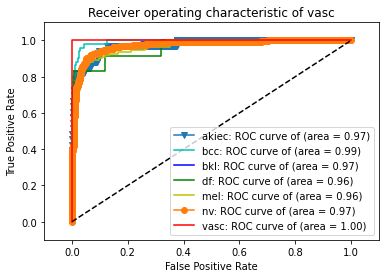

In [56]:
plt.plot(fpr[0], tpr[0],'v-',label='akiec: ROC curve of (area = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1],'c',label='bcc: ROC curve of (area = %0.2f)' % roc_auc[1])
plt.plot(fpr[2], tpr[2],'b',label='bkl: ROC curve of (area = %0.2f)' % roc_auc[2])
plt.plot(fpr[3], tpr[3],'g',label='df: ROC curve of (area = %0.2f)' % roc_auc[3])
plt.plot(fpr[4], tpr[4],'y',label='mel: ROC curve of (area = %0.2f)' % roc_auc[4])
plt.plot(fpr[5], tpr[5],'o-',label='nv: ROC curve of (area = %0.2f)' % roc_auc[5])
plt.plot(fpr[6], tpr[6],'r',label='vasc: ROC curve of (area = %0.2f)' % roc_auc[6])

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of %s'%targetnames[i])
plt.legend(loc="lower right")
plt.show()

### 